In [1]:
import pandas as pd
import datetime as dt
from tqdm import tqdm
import xgboost as xgb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn.metrics import mean_squared_error

# 数据读取

In [2]:
df = pd.DataFrame()
for i in range(1,12):
    df = pd.concat([df,pd.read_csv('../data/%02d.csv'%i)])

In [3]:
df.reset_index(drop=True,inplace=True)

In [4]:
df.groupby('phone_id').time_stamp.count().describe()

count    2.891275e+07
mean     3.609333e+00
std      5.920843e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.454800e+04
Name: time_stamp, dtype: float64

In [5]:
df.groupby('loc_id').time_stamp.count().describe()

count    3.300000e+01
mean     3.162296e+06
std      2.292263e+06
min      8.950620e+05
25%      1.912769e+06
50%      2.592710e+06
75%      3.388435e+06
max      1.077338e+07
Name: time_stamp, dtype: float64

In [6]:
df.phone_id.unique().shape

(28912753,)

In [7]:
df.shape

(104355765, 3)

# 序列构造

In [8]:
seq = df.groupby(['loc_id','time_stamp']).phone_id.count()

In [9]:
seq = seq.reset_index()

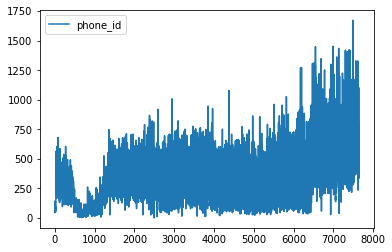

In [10]:
seq[seq.loc_id==1][['time_stamp','phone_id']].plot()

In [11]:
seq.shape

(252013, 3)

# 缺失填补

**这里缺失值分为两类：

**一类是 所有的loc_id在这个时段都没有数据 -> 解决方法：平移前一周的数据来填充这一周的缺失值

**一类是 个别loc_id在这个时段没有数据     -> 解决方法： 选择与缺失值所在loc_id的pearson相关度最高的loc当前时刻的值来填充

In [12]:
# 插值填补
seq.rename(columns={'phone_id':'counts'},inplace=True)
seq2 = seq.pivot(index='time_stamp',columns='loc_id',values='counts')
seq2.index = pd.DatetimeIndex(seq2.index)

In [13]:
from scipy.stats import pearsonr

In [14]:
# pearson fillna
pearson_similarity = np.zeros((33,33))
for col1 in seq2.columns:
    for col2 in seq2.columns:
        pearson_similarity[col1-1,col2-1] = pearsonr(seq2[col1].fillna(0), seq2[col2].fillna(0))[0]

In [15]:
for i in range(0,seq2.shape[0]):
    row = seq2.iloc[i,:]
    for na_col in np.where(row.isnull())[0]:
        similar_rank = pearson_similarity[na_col,:].argsort()
        for j in range(0,len(similar_rank)):
            fillna_col = np.where(similar_rank==j)[0][0]
            if not np.isnan(row[fillna_col + 1]):
                seq2.iloc[i,na_col] = row[fillna_col + 1]
                break

In [16]:
seq2 = seq2.unstack().reset_index()
seq2.time_stamp = seq2.time_stamp.map(lambda x:x.strftime('%Y-%m-%d %H'))
seq2.columns= ['loc_id','time_stamp','counts']
seq = seq2

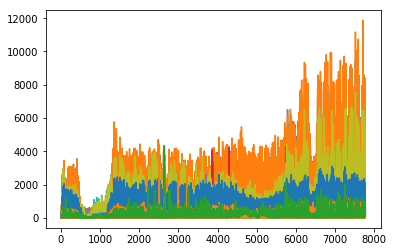

In [17]:
for each in seq.loc_id.unique():
    plt.plot(seq[seq.loc_id==each].counts.values)

In [18]:
move_fill = seq[(seq.time_stamp>='2017-10-12 23') & (seq.time_stamp<='2017-10-13 07')].copy()
move_fill.time_stamp = move_fill['time_stamp'].map(lambda x:x.replace('10-13','10-20').replace('10-12','10-19'))
seq = pd.concat([seq,move_fill])
seq.reset_index(drop=True,inplace=True)

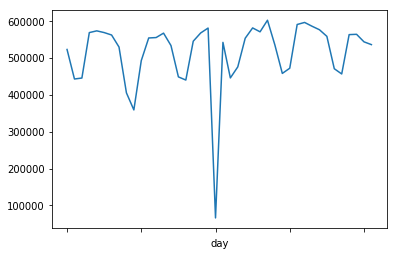

In [19]:
seq['day'] = seq.time_stamp.map(lambda x:x[:-3])
seq[seq.time_stamp>='2017-10-20'].groupby('day').counts.sum().plot()

In [20]:
move_fill2 = seq[(seq.time_stamp>='2017-11-02 01') & (seq.time_stamp<='2017-11-03 01') & (~seq.time_stamp.isin(['2017-11-02 10','2017-11-02 11']))].copy()
move_fill2.time_stamp = move_fill2.time_stamp.map(lambda x:x.replace('11-03','11-10').replace('11-02','11-09'))
seq = pd.concat([seq,move_fill2])
seq.reset_index(drop=True,inplace=True)

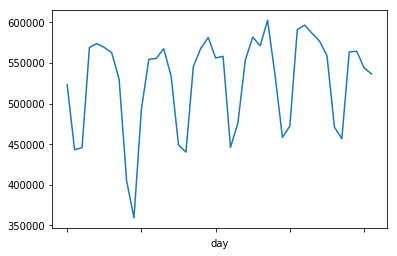

In [21]:
seq['day'] = seq.time_stamp.map(lambda x:x[:-3])
seq[seq.time_stamp>='2017-10-20'].groupby('day').counts.sum().plot()

In [22]:
# 10-29 21 - 10-30 07
move_fill3 = seq[(seq.time_stamp>='2017-10-22 21') & (seq.time_stamp<='2017-10-23 07')].copy()
move_fill3.time_stamp = move_fill3.time_stamp.map(lambda x:x.replace('10-23','10-30').replace('10-22','10-29'))

In [23]:
seq = pd.concat([seq,move_fill3])
seq.reset_index(drop=True,inplace=True)

In [24]:
seq['day'] = seq.time_stamp.map(lambda x:x[:-3])

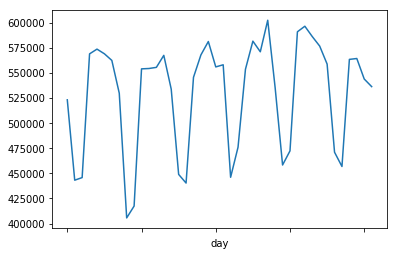

In [25]:
seq[seq.time_stamp>='2017-10-20'].groupby('day').counts.sum().plot()

In [26]:
x = seq[seq.loc_id==1].groupby('day').count().iloc[:,0]
x[x!=24]

day
2017-01-01    20
2017-02-18     9
2017-02-19    22
2017-02-28    10
2017-03-01    22
2017-04-04    21
2017-04-05    13
2017-04-14    18
2017-04-16    22
2017-04-17    16
2017-04-18    22
2017-04-19    22
2017-04-21    22
2017-04-24    10
2017-04-25     9
2017-04-27    16
2017-04-28    22
2017-05-23    16
2017-06-18    21
2017-06-19    15
Name: loc_id, dtype: int64

# 线上测试集

In [27]:
t3 = set()
t = dt.datetime.strptime(seq.time_stamp.max(),'%Y-%m-%d %H') + dt.timedelta(hours=1)
final_day = '2017-12-31 23'
while t <= dt.datetime.strptime(final_day,'%Y-%m-%d %H'):
    s = t.strftime('%Y-%m-%d %H')
    if s not in t3:
        t3.add(s)
    t += dt.timedelta(hours=1)

In [28]:
len(t3) * 33

24552

In [29]:
test_add = []
for loc in tqdm(seq.loc_id.unique()):
    for each in t3:
        test_add.append({'loc_id':loc,'time_stamp':each,'counts':-1})

100%|████████████████████████████████████████| 33/33 [00:00<00:00, 4714.15it/s]


In [30]:
test_add = pd.DataFrame(test_add)
seq = pd.concat([seq,test_add])
seq.reset_index(drop=True,inplace=True)

# 特征构造

In [32]:
seq['datetime'] = seq['time_stamp'].map(lambda x:dt.datetime.strptime(x,'%Y-%m-%d %H'))

seq.sort_values(['loc_id','datetime'],inplace=True)

seq.rename(columns={'phone_id':'counts'},inplace=True)

seq['ymd'] = seq.time_stamp.map(lambda x:x[:-3])

seq['day'] = seq.datetime.map(lambda x:x.day)
seq['hour'] = seq.datetime.map(lambda x:x.hour)
seq['month'] = seq.time_stamp.map(lambda x:int(x[5:7]))
seq['day_of_week'] = seq.datetime.map(lambda x:x.weekday())

seq['week_of_month'] = seq.datetime.map(lambda x:(x.day-1) // 7 + 1)

holidays = ['2016-12-31', '2017-01-01', '2017-01-02', '2017-04-02', '2017-04-03', '2017-04-04', '2017-04-29', '2017-04-30', '2017-05-01', '2017-05-28', '2017-05-29', '2017-05-30', '2017-10-01', '2017-10-02', '2017-10-03', '2017-10-04', '2017-10-05', '2017-10-06', '2017-10-07', '2017-10-08']
vacations = ['2017-01-21', '2017-01-22', '2017-01-23', '2017-01-24', '2017-01-25', '2017-01-26', '2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01', '2017-02-02', '2017-02-03', '2017-02-04', '2017-02-05', '2017-02-06', '2017-02-07', '2017-02-08', '2017-02-09', '2017-02-10', '2017-02-11', '2017-02-12', '2017-02-13', '2017-02-14', '2017-02-15', '2017-02-16', '2017-02-17', '2017-02-18', '2017-02-19', '2017-02-20', '2017-02-21', '2017-02-22', '2017-02-23', '2017-02-24', '2017-02-25', '2017-02-26', '2017-07-15', '2017-07-16', '2017-07-17', '2017-07-18', '2017-07-19', '2017-07-20', '2017-07-21', '2017-07-22', '2017-07-23', '2017-07-24', '2017-07-25', '2017-07-26', '2017-07-27', '2017-07-28', '2017-07-29', '2017-07-30', '2017-07-31', '2017-08-01', '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05', '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09', '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13', '2017-08-14', '2017-08-15', '2017-08-16', '2017-08-17', '2017-08-18', '2017-08-19', '2017-08-20', '2017-08-21', '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25', '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31', '2017-09-01', '2017-09-02', '2017-09-03']

seq['holidays'] = seq['ymd'].isin(holidays).astype(int)
seq['vacations'] = seq['ymd'].isin(vacations).astype(int)
seq['weekends'] = seq['day_of_week'].map(lambda x:int(x>=5))

seq['classday'] = ((seq['holidays'] + seq['vacations'] + seq['weekends'])==0).astype(int)

seq['classhours1'] = seq.hour.map(lambda x:(x>=8 and x<=11) or (x>=13 and x<=16)).astype(int) * seq['classday']
seq['classhours2'] = seq.hour.map(lambda x:(x>=8 and x<=11) or (x>=13 and x<=17) or (x>=18 and x<= 21)).astype(int) * seq['classday']

weathers = pd.read_csv('../features/weather_2017.csv')

del weathers['day'],weathers['month']

seq = seq.merge(weathers,on='ymd',how='left')

# 模型训练

In [33]:
features = ['loc_id', 'hour', 'day',  'day_of_week', 'week_of_month', 'holidays', 'vacations', 'weekends', 'classday', 'classhours1', 'classhours2', 'AqiLevel', 'bWendu', 'fengli', 'yWendu', 'month', 'pollution', 'N', 'S', 'E', 'W', 'wind', 'weather1', 'weather2', 'rain', 'snow', 'wet', 'good_weather']

In [34]:
# 经过试验发现 使用9月份开学之后的数据来训练效果比较好
# 而且要预测的11、12月（A榜和B榜线上测试集），期间没有跨国寒暑假。
train = seq[((seq.datetime>='2017-09-04') & (seq.datetime<'2017-11-01'))]
val = seq[(seq.datetime>='2017-11-01') & (seq.datetime<'2017-12-01')]
test = seq[(seq.datetime>='2017-12-01')]

In [35]:
selected_features = ['loc_id', 'hour', 'classday', 'classhours2', 'weekends', 'day_of_week', 'week_of_month', 'holidays', 'weather2', 'fengli', 'vacations', 'W', 'E', 'snow', 'rain', 'wet', 'wind', 'good_weather', 'bWendu', 'N', 'month', 'S', 'weather1', 'day']


In [37]:
params = {
 'learning_rate' :0.01,
 'max_depth':12,
 'min_child_weight':10,
#  'lambda':0.1,
 'alpha':0.1,
 'gamma':0.01,
#  'subsample':0.9,
 'colsample_bytree':0.3,
 'objective':'reg:linear',#reg:linear
 'eval_metric':'rmse',
 'nthread':8,
 'seed':2018
}

train_mat = xgb.DMatrix(train[selected_features],label=train['counts'])
val_mat = xgb.DMatrix(val[selected_features], label=val['counts'])
model = xgb.train(params,train_mat,num_boost_round=20000,early_stopping_rounds=200,evals=[(val_mat,'val')],verbose_eval=500)

[0]	val-rmse:1114.83
Will train until val-rmse hasn't improved in 200 rounds.
[500]	val-rmse:474.799
[1000]	val-rmse:381.473
[1500]	val-rmse:331.598
[2000]	val-rmse:299.471
[2500]	val-rmse:284.317
[3000]	val-rmse:273.635
[3500]	val-rmse:266.357
[4000]	val-rmse:261.408
[4500]	val-rmse:258.117
[5000]	val-rmse:256.273
[5500]	val-rmse:254.989
[6000]	val-rmse:253.664
[6500]	val-rmse:253.287
[7000]	val-rmse:252.751
[7500]	val-rmse:252.523
[8000]	val-rmse:252.277
[8500]	val-rmse:251.987
[9000]	val-rmse:251.905
[9500]	val-rmse:251.685
Stopping. Best iteration:
[9595]	val-rmse:251.629



In [38]:
# 使用全部数据来训练，用来预测线上测试集
train = seq[(seq.datetime>='2017-09-04') & (seq.datetime<'2017-12-01')]
train_mat = xgb.DMatrix(train[selected_features],label=train['counts'])
test_mat = xgb.DMatrix(test[selected_features])
model_ol = xgb.train(params,train_mat,num_boost_round=model.best_iteration + 10)

In [106]:
test['num_of_people'] = model_ol.predict(test_mat)
save = test[['loc_id','time_stamp','num_of_people']]
save.sort_values(['time_stamp','loc_id'],inplace=True)

C:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [100]:
save.loc[save.num_of_people<0,'num_of_people'] = 10

C:\Program Files\Python36\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [102]:
save.to_csv('../result/result_xgb.csv',index=False)

In [ ]:
save.shape